In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

## 1. static pictures

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

In [3]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                 connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))     
        
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

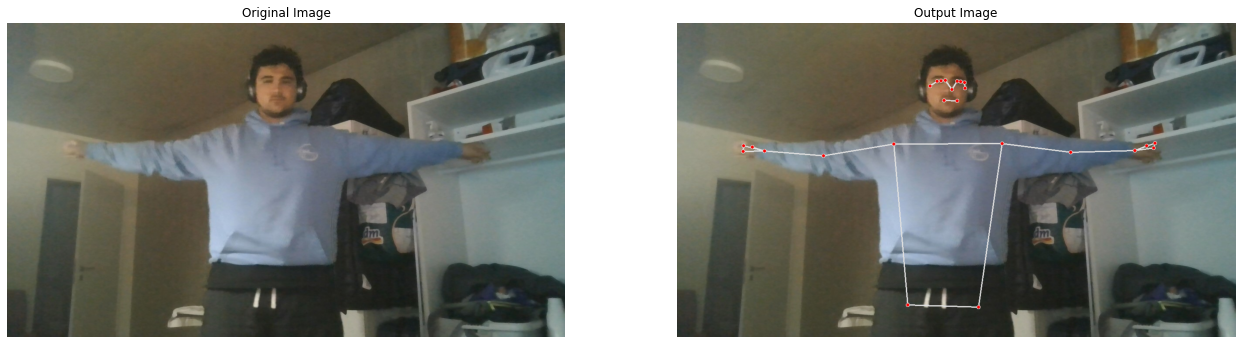

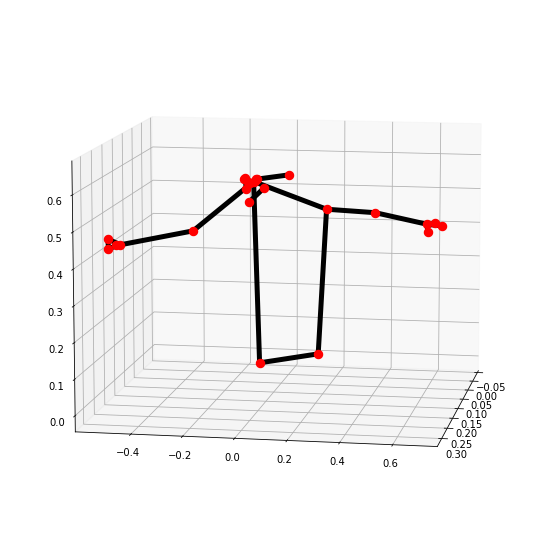

In [4]:
image = cv2.imread(r'C:\DLAV_testing\images to test\test_angle2.jpg')
detectPose(image, pose, display=True)

# 2.Webcam Pose Detection

In [5]:
# Setup Pose function for video.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
video = cv2.VideoCapture(0)

# Create named window for resizing purposes
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)


# Initialize the VideoCapture object to read from a video stored in the disk.
#video = cv2.VideoCapture('media/running.mp4')

# Set video camera size
video.set(3,1280)
video.set(4,960)

# Initialize a variable to store the time of the previous frame.
time1 = 0

# Iterate until the video is accessed successfully.
while video.isOpened():
    
    # Read a frame.
    ok, frame = video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Break the loop.
        break
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape
    
    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Perform Pose landmark detection.
    frame, _ = detectPose(frame, pose_video, display=False)
    
    # Set the time for this frame to the current time.
    time2 = time()
    
    # Check if the difference between the previous and this frame time > 0 to avoid division by zero.
    if (time2 - time1) > 0:
    
        # Calculate the number of frames per second.
        frames_per_second = 1.0 / (time2 - time1)
        
        # Write the calculated number of frames per second on the frame. 
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # Update the previous frame time to this frame time.
    # As this frame will become previous frame in next iteration.
    time1 = time2
    
    # Display the frame.
    cv2.imshow('Pose Detection', frame)
        # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break

# Release the VideoCapture object.
video.release()

# Close the windows.
cv2.destroyAllWindows()

# 3. Classification

In [6]:
def calculateAngle(landmark1, landmark2, landmark3):
    '''
    This function calculates angle between three different landmarks.
    Args:
        landmark1: The first landmark containing the x,y and z coordinates.
        landmark2: The second landmark containing the x,y and z coordinates.
        landmark3: The third landmark containing the x,y and z coordinates.
    Returns:
        angle: The calculated angle between the three landmarks.

    '''

    # Get the required landmarks coordinates.
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    # Calculate the angle between the three points
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    angle = np.abs(angle)
    # Check if the angle is less than zero.
    if angle > 180:

        # Add 360 to the found angle.
        angle = 360-angle
    
    # Return the calculated angle.
    return angle

In [7]:
def classifyPose(landmarks, output_image, display=False):
    '''
    This function classifies yoga poses depending upon the angles of various body joints.
    Args:
        landmarks: A list of detected landmarks of the person whose pose needs to be classified.
        output_image: A image of the person with the detected pose landmarks drawn.
        display: A boolean value that is if set to true the function displays the resultant image with the pose label 
        written on it and returns nothing.
    Returns:
        output_image: The image with the detected pose landmarks drawn and pose label written.
        label: The classified pose label of the person in the output_image.

    '''
    
    # Initialize the label of the pose. It is not known at this stage.
    label = 'Unknown Pose'

    # Specify the color (Red) with which the label will be written on the image.
    color = (0, 0, 255)
    
    # Calculate the required angles.
    #----------------------------------------------------------------------------------------------------------------
    
    # Get the angle between the left shoulder, elbow and wrist points. 
    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if it is the warrior II pose or the T pose.
    # As for both of them, both arms should be straight and shoulders should be at the specific angle.
    #----------------------------------------------------------------------------------------------------------------
    
    # Check if the both arms are straight.
    if left_elbow_angle > 125 and left_elbow_angle < 220 and right_elbow_angle > 125 and right_elbow_angle < 220:
        #label = 'T Pose'
        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 110:
            label = 'T Pose'
                        
    if right_elbow_angle > 50 and right_elbow_angle < 130 and right_shoulder_angle > 70 and right_shoulder_angle < 110:
        label = "power to the people"
        
    # Check if the pose is classified successfully
    if label != 'Unknown Pose':
        
        # Update the color (to green) with which the label will be written on the image.
        color = (0, 255, 0)  
    
    # Write the label on the output image. 
    cv2.putText(output_image, label, (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    
    # Check if the resultant image is specified to be displayed.
    if display:
    
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    else:
        
        # Return the output image and the classified label.
        return output_image, label

## 3.1 Webcam Pose Classification

In [8]:
# Setup Pose function for video.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Initialize the VideoCapture object to read from the webcam.
#camera_video = cv2.VideoCapture(0)
camera_video = cv2.VideoCapture("C:\DLAV_testing\images to test\pexels-rodnae-productions-7502734.mp4")
#camera_video.set(3,1280)
#camera_video.set(4,960)

# Initialize a resizable window.
cv2.namedWindow('Pose Classification', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly.
    if not ok:
        
        # Continue to the next iteration to read the next frame and ignore the empty camera frame.
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the width and height of the frame
    frame_height, frame_width, _ =  frame.shape 
    
    # Resize the frame while keeping the aspect ratio.
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    # Perform Pose landmark detection.
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    # Check if the landmarks are detected.
    if landmarks:
        
        # Perform the Pose Classification.
        frame, _ = classifyPose(landmarks, frame, display=False)
    
    # Display the frame.
    cv2.imshow('Pose Classification', frame)
    
    # Wait until a key is pressed.
    # Retreive the ASCII code of the key pressed
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed.
    if(k == 27):
        
        # Break the loop.
        break

# Release the VideoCapture object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
cv2.destroyAllWindows()